In [1]:
import numpy as np
from multiprocessing import cpu_count
from dimension_reduction_methods import LocalityPreservingProjection, pca_wrapper
from localized_pvalue_estimation import averaged_KLPE_anomaly_detection
from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve
)
from utils import (
    wrapper_data_generate, 
    metrics_detection
)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# Define some constants
n_jobs = max(cpu_count() - 2, 1)
seed_rng = np.random.randint(1, high=10000)
metric_primary = 'cosine'
shared_nearest_neighbors = True

# Neighborhood size is chosen as a function of the number of data points. 
# In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
neighborhood_constant = 0.42

max_fpr_pauc = 0.01

COLORS = ['r', 'b', 'g', 'y', 'orange', 'm', 'lawngreen', 'gold', 'c', 'hotpink']

In [3]:
# Generate data according to a mixture of factor analysis (MFA) model
np.random.seed(seed_rng)

# number of mixture components
n_components = 10
# dimension of the observed space
dim = 100
# Specify a range for the latent dimension
dim_latent_range = (10, 20)

# Number of training points, test points, and proportion of anomalies in the test data
N = 1000
N_test = 1000
prop_anomaly = 0.1

data, data_test, labels_test = wrapper_data_generate(dim, dim_latent_range, n_components, 
                                                     N, N_test, prop_anomaly=prop_anomaly, 
                                                     anom_type='gaussian', seed_rng=seed_rng)

In [4]:
# Locality preserving projection method
model_lpp = LocalityPreservingProjection(
    dim_projection=3, 
    orthogonal=False, 
    pca_cutoff=1.0, 
    neighborhood_constant=neighborhood_constant, 
    shared_nearest_neighbors=shared_nearest_neighbors, 
    edge_weights='SNN',      # Choices are {'simple', 'SNN', 'heat_kernel'}
    metric=metric_primary, 
    approx_nearest_neighbors=True, 
    n_jobs=n_jobs, 
    seed_rng=seed_rng
)
model_lpp.fit(data)
data_proj = model_lpp.transform(data)
data_test_proj = model_lpp.transform(data_test)

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


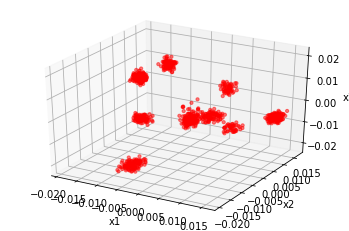

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_proj[:, 0], data_proj[:, 1], data_proj[:, 2], 
           marker='o', c='r', s=10, alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.show()

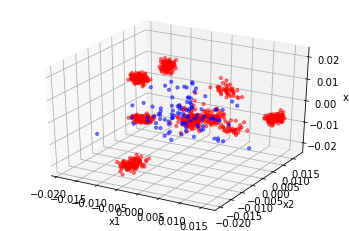

In [6]:
c = [COLORS[v] for v in labels_test]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_test_proj[:, 0], data_test_proj[:, 1], data_test_proj[:, 2], 
           marker='o', c=c, s=10, alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.show()

In [7]:
# PCA projection
data_proj, mean_data, transform_pca = pca_wrapper(data, dim_red=3, seed_rng=seed_rng)
data_test_proj = np.dot(data_test - mean_data, transform_pca)

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3


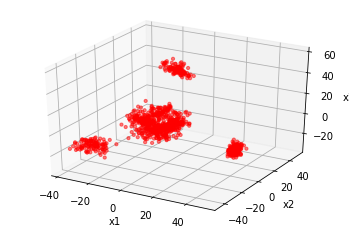

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_proj[:, 0], data_proj[:, 1], data_proj[:, 2], 
           marker='o', c='r', s=10, alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.show()

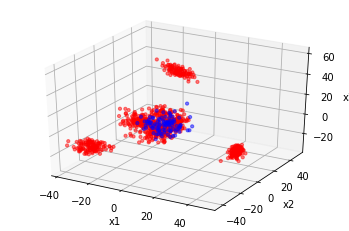

In [9]:
c = [COLORS[v] for v in labels_test]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_test_proj[:, 0], data_test_proj[:, 1], data_test_proj[:, 2], 
           marker='o', c=c, s=10, alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.show()